In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
with open('/content/kcc.json') as file:
  data = json.load(file)

data

{'intents': [{'tag': 'GOURD VARIETIES',
   'patterns': ['RIDGE GOURD VARIETIES',
    'RIDGE GOURD VARIETIES in telanaga',
    'Poṭlakāya varieties'],
   'responses': ['RIDGE GOURD VARIETIES ;-SUREKA ,SANJIVANI,MAHIMA,NS-3 ,401,403'],
   'context': ['']},
  {'tag': 'BEANS SOWING',
   'patterns': ['BEANS SOWING TIME?', 'BEANS SOWING TIME in telangana'],
   'responses': ['BEANS SOWING TIME ;- JUNE -JULY '],
   'context': ['']},
  {'tag': 'Plant Protection',
   'patterns': ['WHITE FLY MANAGEMENT IN CUCUMBER', 'WHITE FLY MANAGEMENT'],
   'responses': ['RECOMMENDED TO SPRAY ACEPHATE (ARTHIN) 300 GRAMS/ 200 LITRES OF WATER / ACRE \n(OR)\nRECOMMENDED TO SPRAY THIAMETHOXAM (ACTARA/CRULSER) 40 GRAMS /200 LITRES OF WATER / ACRE '],
   'context': ['']},
  {'tag': 'BASMATHI Seeds',
   'patterns': ['BASMATHI SEED VARIETIES ?',
    'BASMATHI SEED VARIETIES in telangana?',
    'PADDY BASMATHI VARIETIES'],
   'responses': ['These are Basmati 217, Basmati 370, Type 3 (Dehraduni Basmati) Punjab Basmati 1

In [ ]:
import json
import pandas as pd

def frame_data(feat_1,feat_2,is_pattern):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[feat_1,feat_2])
  for intent in data['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        df_to_append = pd.Series([w,intent['tag']], index = df.columns)
        df = df.append(df_to_append,ignore_index=True)
    else:
      for response in intent['responses']:
        w = response
        df_to_append = pd.Series([w,intent['tag']], index = df.columns)
        df = df.append(df_to_append,ignore_index=True)
  return df

# Example usage
df1 = frame_data('questions','labels', True)
df1.head()


<ipython-input-7-8fe6f714d0be>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

,questions,labels
0,RIDGE GOURD VARIETIES,GOURD VARIETIES
1,RIDGE GOURD VARIETIES in telanaga,GOURD VARIETIES
2,Poṭlakāya varieties,GOURD VARIETIES
3,BEANS SOWING TIME?,BEANS SOWING
4,BEANS SOWING TIME in telangana,BEANS SOWING


In [ ]:
df2 = frame_data('response','labels', False)
df2.head()

<ipython-input-7-8fe6f714d0be>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
<ipython-input-7-8fe6f714d0be>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

,response,labels
0,"RIDGE GOURD VARIETIES ;-SUREKA ,SANJIVANI,MAHI...",GOURD VARIETIES
1,BEANS SOWING TIME ;- JUNE -JULY,BEANS SOWING
2,RECOMMENDED TO SPRAY ACEPHATE (ARTHIN) 300 GRA...,Plant Protection
3,"These are Basmati 217, Basmati 370, Type 3 (De...",BASMATHI Seeds
4,RECOMMENDED TO SOW FROM JUNE 3RD WEEK.,RNR PADDY SEEDS


In [ ]:
(df1.labels.value_counts(sort=False))

GOURD VARIETIES            3
BEANS SOWING               2
Plant Protection           2
BASMATHI Seeds             3
RNR PADDY SEEDS            2
CLUSTER BEANS              2
CHILLI SOWING              2
VARIETIES OF CHILLI        2
LEAF EATING CATERPILLER    2
Weed Management            2
Name: labels, dtype: int64

## Data preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [ ]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return

In [ ]:
create_vocab(tokenizer,df1,'questions')

In [ ]:
vocab

Counter({'ridge': 2,
         'gourd': 2,
         'variety': 10,
         'in': 9,
         'telanaga': 1,
         'poṭlakāya': 1,
         'bean': 4,
         'sowing': 6,
         'time': 5,
         'telangana': 6,
         'white': 2,
         'fly': 2,
         'management': 6,
         'cucumber': 1,
         'basmathi': 3,
         'seed': 4,
         'paddy': 4,
         'of': 8,
         'rnr': 2,
         'cluster': 2,
         'chilli': 4,
         'leaf': 1,
         'eating': 1,
         'caterpiller': 2,
         'nursery': 1,
         'weed': 2,
         'napier': 2,
         'grass': 2})

In [ ]:
vocab_size = len(vocab)
vocab_size

28

In [ ]:
df1.groupby(by='labels',as_index=False).first()['questions']

0                            BASMATHI SEED VARIETIES ?
1                                   BEANS SOWING TIME?
2                                        CHILLI SOWING
3                           VARIETIES OF CLUSTER BEANS
4                                RIDGE GOURD VARIETIES
5    LEAF EATING CATERPILLER IN PADDY NURSERY MANAG...
6                     WHITE FLY MANAGEMENT IN CUCUMBER
7                      SOWING TIME OF RNR PADDY SEEDS?
8                                 VARIETIES OF CHILLI?
9                     WEED MANAGEMENT of NAPIER GRASS?
Name: questions, dtype: object

In [ ]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['BASMATHI SEED VARIETIES ?',
 'BEANS SOWING TIME?',
 'CHILLI SOWING',
 'VARIETIES OF CLUSTER BEANS',
 'RIDGE GOURD VARIETIES',
 'LEAF EATING CATERPILLER IN PADDY NURSERY MANAGEMENT?',
 'WHITE FLY MANAGEMENT IN CUCUMBER',
 'SOWING TIME OF RNR PADDY SEEDS?',
 'VARIETIES OF CHILLI?',
 'WEED MANAGEMENT of NAPIER GRASS?']

In [ ]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[7, 3, 14, 12, 0, 18, 5, 10, 16, 20]

In [ ]:
# train indices are the all indices minus the testing indices

train_index = [i for i in df1.index if i not in test_index]
train_index

[1, 2, 4, 6, 8, 9, 11, 13, 15, 17, 19, 21]

In [ ]:
def convert_seq(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    print('----')
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')   # why a pkl file
    vocab_size = len(t.word_index) +1 # +1 for oov
    print(t.word_index)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print('----')
    print("max length of string is : ",max_length)
    print('----')
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    print('----')
    print(padded)
    return padded, vocab_size

In [ ]:
X,vocab_size = convert_seq(df1,'questions')

['RIDGE GOURD VARIETIES', 'RIDGE GOURD VARIETIES in telanaga', 'Poṭlakāya varieties', 'BEANS SOWING TIME?', 'BEANS SOWING TIME in telangana', 'WHITE FLY MANAGEMENT IN CUCUMBER', 'WHITE FLY MANAGEMENT', 'BASMATHI SEED VARIETIES ?', 'BASMATHI SEED VARIETIES in telangana?', 'PADDY BASMATHI VARIETIES', 'SOWING TIME OF RNR PADDY SEEDS?', 'SOWING TIME OF RNR PADDY SEEDS in telangana', 'VARIETIES OF CLUSTER BEANS', 'VARIETIES OF CLUSTER BEANS in telangana', 'CHILLI SOWING', 'CHILLI SOWING time?', 'VARIETIES OF CHILLI?', 'VARIETIES OF CHILLI in telangana?', 'LEAF EATING CATERPILLER IN PADDY NURSERY MANAGEMENT?', 'CATERPILLER MANAGEMENT?', 'WEED MANAGEMENT of NAPIER GRASS?', 'WEED MANAGEMENT of NAPIER GRASS in telangana?']
----
{'varieties': 1, 'in': 2, 'of': 3, 'sowing': 4, 'telangana': 5, 'management': 6, 'time': 7, 'beans': 8, 'paddy': 9, 'chilli': 10, 'basmathi': 11, 'ridge': 12, 'gourd': 13, 'white': 14, 'fly': 15, 'seed': 16, 'rnr': 17, 'seeds': 18, 'cluster': 19, 'caterpiller': 20, 'weed

In [ ]:
with open('tokenizer_t.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data.index_word

{1: 'varieties',
 2: 'in',
 3: 'of',
 4: 'sowing',
 5: 'telangana',
 6: 'management',
 7: 'time',
 8: 'beans',
 9: 'paddy',
 10: 'chilli',
 11: 'basmathi',
 12: 'ridge',
 13: 'gourd',
 14: 'white',
 15: 'fly',
 16: 'seed',
 17: 'rnr',
 18: 'seeds',
 19: 'cluster',
 20: 'caterpiller',
 21: 'weed',
 22: 'napier',
 23: 'grass',
 24: 'telanaga',
 25: 'poṭlakāya',
 26: 'cucumber',
 27: 'leaf',
 28: 'eating',
 29: 'nursery'}

In [ ]:
data.word_counts

OrderedDict([('ridge', 2),
             ('gourd', 2),
             ('varieties', 10),
             ('in', 9),
             ('telanaga', 1),
             ('poṭlakāya', 1),
             ('beans', 4),
             ('sowing', 6),
             ('time', 5),
             ('telangana', 6),
             ('white', 2),
             ('fly', 2),
             ('management', 6),
             ('cucumber', 1),
             ('basmathi', 3),
             ('seed', 2),
             ('paddy', 4),
             ('of', 8),
             ('rnr', 2),
             ('seeds', 2),
             ('cluster', 2),
             ('chilli', 4),
             ('leaf', 1),
             ('eating', 1),
             ('caterpiller', 2),
             ('nursery', 1),
             ('weed', 2),
             ('napier', 2),
             ('grass', 2)])

In [ ]:
X

array([[12, 13,  1,  0,  0,  0,  0,  0],
       [12, 13,  1,  2, 24,  0,  0,  0],
       [25,  1,  0,  0,  0,  0,  0,  0],
       [ 8,  4,  7,  0,  0,  0,  0,  0],
       [ 8,  4,  7,  2,  5,  0,  0,  0],
       [14, 15,  6,  2, 26,  0,  0,  0],
       [14, 15,  6,  0,  0,  0,  0,  0],
       [11, 16,  1,  0,  0,  0,  0,  0],
       [11, 16,  1,  2,  5,  0,  0,  0],
       [ 9, 11,  1,  0,  0,  0,  0,  0],
       [ 4,  7,  3, 17,  9, 18,  0,  0],
       [ 4,  7,  3, 17,  9, 18,  2,  5],
       [ 1,  3, 19,  8,  0,  0,  0,  0],
       [ 1,  3, 19,  8,  2,  5,  0,  0],
       [10,  4,  0,  0,  0,  0,  0,  0],
       [10,  4,  7,  0,  0,  0,  0,  0],
       [ 1,  3, 10,  0,  0,  0,  0,  0],
       [ 1,  3, 10,  2,  5,  0,  0,  0],
       [27, 28, 20,  2,  9, 29,  6,  0],
       [20,  6,  0,  0,  0,  0,  0,  0],
       [21,  6,  3, 22, 23,  0,  0,  0],
       [21,  6,  3, 22, 23,  2,  5,  0]], dtype=int32)

In [ ]:
vocab_size

30

In [ ]:
df_encoded = pd.DataFrame(X)
df_encoded

,0,1,2,3,4,5,6,7
0,12,13,1,0,0,0,0,0
1,12,13,1,2,24,0,0,0
2,25,1,0,0,0,0,0,0
3,8,4,7,0,0,0,0,0
4,8,4,7,2,5,0,0,0
5,14,15,6,2,26,0,0,0
6,14,15,6,0,0,0,0,0
7,11,16,1,0,0,0,0,0
8,11,16,1,2,5,0,0,0
9,9,11,1,0,0,0,0,0


In [ ]:
df_encoded['labels'] = df1.labels
df_encoded.head(10)

,0,1,2,3,4,5,6,7,labels
0,12,13,1,0,0,0,0,0,GOURD VARIETIES
1,12,13,1,2,24,0,0,0,GOURD VARIETIES
2,25,1,0,0,0,0,0,0,GOURD VARIETIES
3,8,4,7,0,0,0,0,0,BEANS SOWING
4,8,4,7,2,5,0,0,0,BEANS SOWING
5,14,15,6,2,26,0,0,0,Plant Protection
6,14,15,6,0,0,0,0,0,Plant Protection
7,11,16,1,0,0,0,0,0,BASMATHI Seeds
8,11,16,1,2,5,0,0,0,BASMATHI Seeds
9,9,11,1,0,0,0,0,0,BASMATHI Seeds


In [ ]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

# encoding the labels

labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([4, 4, 4, 1, 1, 6, 6, 0, 0, 0, 7, 7, 3, 3, 2, 2, 8, 8, 5, 5, 9, 9])

In [ ]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]

mapper

{'GOURD VARIETIES': 4,
 'BEANS SOWING': 1,
 'Plant Protection': 6,
 'BASMATHI Seeds': 0,
 'RNR PADDY SEEDS': 7,
 'CLUSTER BEANS': 3,
 'CHILLI SOWING': 2,
 'VARIETIES OF CHILLI': 8,
 'LEAF EATING CATERPILLER': 5,
 'Weed Management': 9}

In [ ]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,"RIDGE GOURD VARIETIES ;-SUREKA ,SANJIVANI,MAHI...",4
1,BEANS SOWING TIME ;- JUNE -JULY,1
2,RECOMMENDED TO SPRAY ACEPHATE (ARTHIN) 300 GRA...,6
3,"These are Basmati 217, Basmati 370, Type 3 (De...",0
4,RECOMMENDED TO SOW FROM JUNE 3RD WEEK.,7


In [ ]:
df2.to_csv('response.csv',index=False)

In [ ]:
df_encoded.head()

,0,1,2,3,4,5,6,7,labels
0,12,13,1,0,0,0,0,0,GOURD VARIETIES
1,12,13,1,2,24,0,0,0,GOURD VARIETIES
2,25,1,0,0,0,0,0,0,GOURD VARIETIES
3,8,4,7,0,0,0,0,0,BEANS SOWING
4,8,4,7,2,5,0,0,0,BEANS SOWING


In [ ]:
train_index

[1, 2, 4, 6, 8, 9, 11, 13, 15, 17, 19, 21]

In [ ]:
test_index

[7, 3, 14, 12, 0, 18, 5, 10, 16, 20]

In [ ]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [ ]:
train

,0,1,2,3,4,5,6,7,labels
1,12,13,1,2,24,0,0,0,GOURD VARIETIES
2,25,1,0,0,0,0,0,0,GOURD VARIETIES
4,8,4,7,2,5,0,0,0,BEANS SOWING
6,14,15,6,0,0,0,0,0,Plant Protection
8,11,16,1,2,5,0,0,0,BASMATHI Seeds
9,9,11,1,0,0,0,0,0,BASMATHI Seeds
11,4,7,3,17,9,18,2,5,RNR PADDY SEEDS
13,1,3,19,8,2,5,0,0,CLUSTER BEANS
15,10,4,7,0,0,0,0,0,CHILLI SOWING
17,1,3,10,2,5,0,0,0,VARIETIES OF CHILLI


In [ ]:
test.head()

,0,1,2,3,4,5,6,7,labels
7,11,16,1,0,0,0,0,0,BASMATHI Seeds
3,8,4,7,0,0,0,0,0,BEANS SOWING
14,10,4,0,0,0,0,0,0,CHILLI SOWING
12,1,3,19,8,0,0,0,0,CLUSTER BEANS
0,12,13,1,0,0,0,0,0,GOURD VARIETIES


In [ ]:
train.labels.value_counts()

GOURD VARIETIES            2
BASMATHI Seeds             2
BEANS SOWING               1
Plant Protection           1
RNR PADDY SEEDS            1
CLUSTER BEANS              1
CHILLI SOWING              1
VARIETIES OF CHILLI        1
LEAF EATING CATERPILLER    1
Weed Management            1
Name: labels, dtype: int64

In [ ]:
test.labels.value_counts()

BASMATHI Seeds             1
BEANS SOWING               1
CHILLI SOWING              1
CLUSTER BEANS              1
GOURD VARIETIES            1
LEAF EATING CATERPILLER    1
Plant Protection           1
RNR PADDY SEEDS            1
VARIETIES OF CHILLI        1
Weed Management            1
Name: labels, dtype: int64

In [ ]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7
1,12,13,1,2,24,0,0,0
2,25,1,0,0,0,0,0,0
4,8,4,7,2,5,0,0,0
6,14,15,6,0,0,0,0,0
8,11,16,1,2,5,0,0,0


In [ ]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [ ]:
max_length = X_train.shape[1]
output = 16

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #patience : number of epochs with no improvement after which training will be stopped

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [early_stopping,checkpoint,reduce_lr]

In [ ]:
y_train[0].shape,y_test[0].shape

((10,), (10,))

In [ ]:
X_train.shape

(12, 8)

In [ ]:
X_test.shape

(10, 8)

In [ ]:
X_train

,0,1,2,3,4,5,6,7
1,12,13,1,2,24,0,0,0
2,25,1,0,0,0,0,0,0
4,8,4,7,2,5,0,0,0
6,14,15,6,0,0,0,0,0
8,11,16,1,2,5,0,0,0
9,9,11,1,0,0,0,0,0
11,4,7,3,17,9,18,2,5
13,1,3,19,8,2,5,0,0
15,10,4,7,0,0,0,0,0
17,1,3,10,2,5,0,0,0


## LSTM

In [ ]:
max_length

8

In [ ]:
vocab_size

30

In [ ]:
def define_model1(vocab_size, max_length):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(10, activation='softmax'))

    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [ ]:
model1 = define_model1(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 100)            3000      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 24,110
Trainable params: 24,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)#,callbacks=callbacks)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 2.2989 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.22969, saving model to model-v1.h5
1/1 [==============================] - 7s 7s/step - loss: 2.2989 - accuracy: 0.0000e+00 - val_loss: 2.2297 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 2.1966 - accuracy: 0.4167
Epoch 2: val_loss improved from 2.22969 to 2.16254, saving model to model-v1.h5
1/1 [==============================] - 0s 142ms/step - loss: 2.1966 - accuracy: 0.4167 - val_loss: 2.1625 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 2.0957 - accuracy: 0.5833
Epoch 3: val_loss improved from 2.16254 to 2.09477, saving model to model-v1.h5
1/1 [==============================] - 0s 125ms/step - loss: 2.0957 - accuracy: 0.5833 - val_loss: 2.0948 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0s

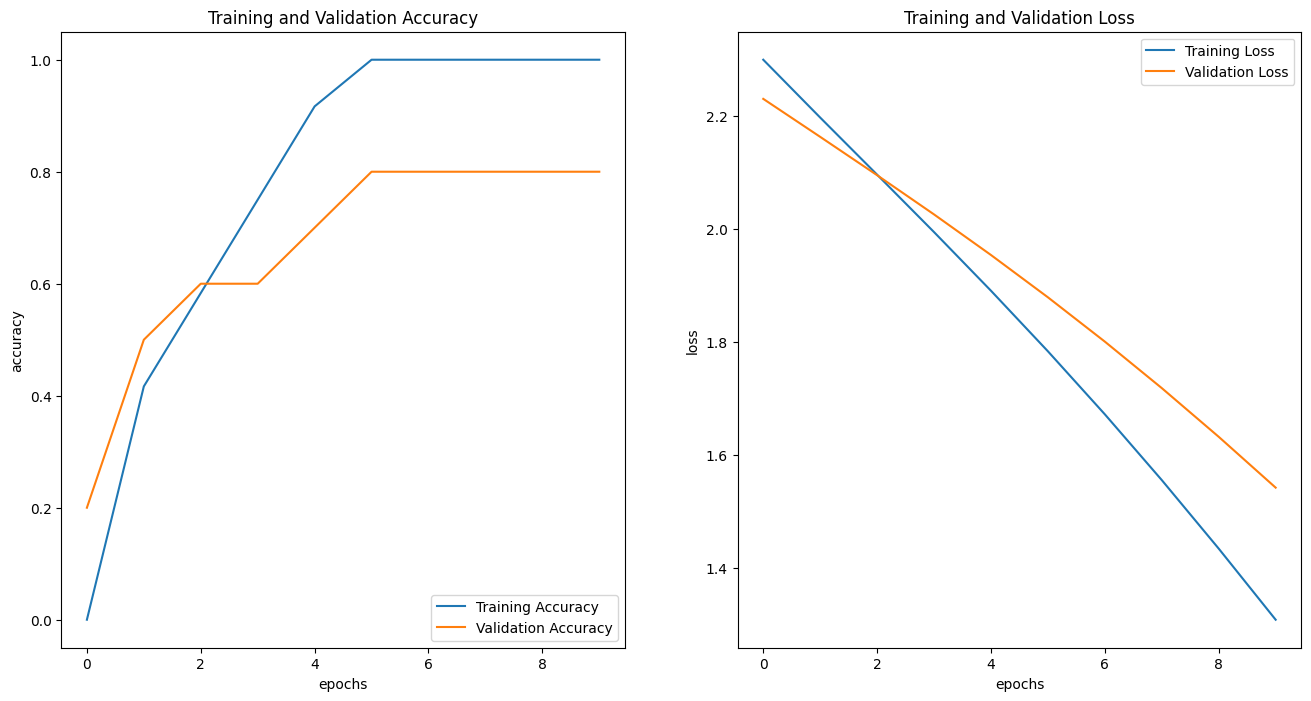

In [ ]:

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [ ]:
model1.save("AI_lstm_model.h5")

## Predictions

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
def get_text(str_text):
    # print(str_text)
    input_text  = [str_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [ ]:
from tensorflow.keras.models import load_model
model = model1
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [ ]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [ ]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [ ]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=8, padding='post')
    return padded

In [ ]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [ ]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [ ]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

In [ ]:
def bot_response(response,):
    print(response)

In [ ]:
df_input = get_text("white fly manaegment")

# load artifacts
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model1,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 188ms/step
RECOMMENDED TO SPRAY ACEPHATE (ARTHIN) 300 GRAMS/ 200 LITRES OF WATER / ACRE 
(OR)
RECOMMENDED TO SPRAY THIAMETHOXAM (ACTARA/CRULSER) 40 GRAMS /200 LITRES OF WATER / ACRE 
